In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D

df = pd.read_parquet('green_tripdata_2016-12.parquet')
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2016-12-01 00:13:25,2016-12-01 00:25:41,N,1,225,65,1,2.79,11.0,0.5,0.5,0.00,0.0,None,0.3,12.30,2,1,None
1,2,2016-12-01 00:06:47,2016-12-01 00:08:52,N,1,255,255,1,0.45,3.5,0.5,0.5,0.96,0.0,None,0.3,5.76,1,1,None
2,1,2016-12-01 00:29:45,2016-12-01 00:34:21,N,1,41,42,1,1.20,6.0,0.5,0.5,0.00,0.0,None,0.3,7.30,3,1,None
3,1,2016-12-01 00:05:43,2016-12-01 00:11:56,N,1,80,255,1,1.40,6.5,0.5,0.5,0.00,0.0,None,0.3,7.80,2,1,None
4,1,2016-12-01 00:47:13,2016-12-01 01:02:59,N,1,255,189,1,3.50,13.5,0.5,0.5,3.70,0.0,None,0.3,18.50,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224153,2,2016-12-31 23:30:44,2016-12-31 23:45:14,N,1,145,129,1,3.60,14.0,0.5,0.5,3.82,0.0,None,0.3,19.12,1,1,None
1224154,2,2016-12-31 23:06:19,2016-12-31 23:23:55,N,1,97,89,1,2.63,13.5,0.5,0.5,0.00,0.0,None,0.3,14.80,2,1,None
1224155,2,2016-12-31 23:28:06,2016-12-31 23:34:30,N,1,188,190,1,1.29,7.0,0.5,0.5,0.00,0.0,None,0.3,8.30,2,1,None
1224156,1,2016-12-31 23:05:35,2016-12-31 23:11:41,N,1,116,244,2,1.00,6.5,0.5,0.5,1.00,0.0,None,0.3,8.80,1,1,None


In [2]:
# two columns are all NaN. Other columns have no NaN.
df.isna().sum()

VendorID                       0
lpep_pickup_datetime           0
lpep_dropoff_datetime          0
store_and_fwd_flag             0
RatecodeID                     0
PULocationID                   0
DOLocationID                   0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
ehail_fee                1224158
improvement_surcharge          0
total_amount                   0
payment_type                   0
trip_type                      0
congestion_surcharge     1224158
dtype: int64

In [3]:
#  We drop the two NaN columns
df = df.drop(columns=['ehail_fee', 'congestion_surcharge'])

In [4]:
# Now let's go through each column and check whether there is any inconsistencies in the type of data used
# like strings mixed with integers, Timestamp types mixed with strings, ...

In [5]:
# we have two types of vendors:
set(df.VendorID)

{1, 2}

In [6]:
# 20% venodrID=1 and 80% vendorID=2
df.VendorID.value_counts()

2    978443
1    245715
Name: VendorID, dtype: int64

In [7]:
#type of data for column VendorID seems okay and consistent
set(type(x) for x in df.VendorID)

{int}

In [8]:
# column lpep_pickup_datetime
# the dates are in Timestamp formmat which makes our work easier in handling date/time data
set(type(x) for x in df.lpep_pickup_datetime)

{pandas._libs.tslibs.timestamps.Timestamp}

In [9]:
# column lpep_dropoff_datetime
set(type(x) for x in df.lpep_dropoff_datetime)

{pandas._libs.tslibs.timestamps.Timestamp}

In [10]:
# difference between dropoff and pickup, these all should be a positive number 
# and mainly in the order of minutes 
dif = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
dif

0         0 days 00:12:16
1         0 days 00:02:05
2         0 days 00:04:36
3         0 days 00:06:13
4         0 days 00:15:46
                ...      
1224153   0 days 00:14:30
1224154   0 days 00:17:36
1224155   0 days 00:06:24
1224156   0 days 00:06:06
1224157   0 days 00:09:23
Length: 1224158, dtype: timedelta64[ns]

In [11]:
# but we have cases as long as a 42 hours trip and a zero-second trip
# the zero one might be a mistake or a cancelled trip; the 42 hours one also seems a mistake but 
# could be right as well; maybe somebody rented the taxi for two full days.
max(dif), min(dif)

(Timedelta('1 days 17:27:54'), Timedelta('0 days 00:00:00'))

In [12]:
# column "store_and_fwd_flag"
df.store_and_fwd_flag.value_counts()
# two values 

N    1222074
Y       2084
Name: store_and_fwd_flag, dtype: int64

In [13]:
# column: "RatecodeID"
# 6 unique values
df.RatecodeID.value_counts()

1    1195018
5      24212
2       3303
3        914
4        692
6         19
Name: RatecodeID, dtype: int64

In [16]:
# column "PULocationID"
# 241 unique values 
df.PULocationID.value_counts()

74     71318
41     69418
7      62206
75     61934
82     57920
       ...  
161        1
90         1
204        1
27         1
233        1
Name: PULocationID, Length: 241, dtype: int64

In [15]:
# column "DOLocationID"
# 260 unique values 
df.DOLocationID.value_counts()

42     41063
74     40768
7      38183
41     37141
129    37040
       ...  
204        5
176        5
44         4
110        1
99         1
Name: DOLocationID, Length: 260, dtype: int64

In [17]:
# column "passenger_count"
# all trips had a minimum of zero passenger (for 173 trips, probably delivering goods to an addresss)
# and a maximum of 9 passengers (12 trips)
df.passenger_count.value_counts()

1    1033788
2      93550
5      43479
3      24471
6      20530
4       8085
0        173
8         36
7         34
9         12
Name: passenger_count, dtype: int64

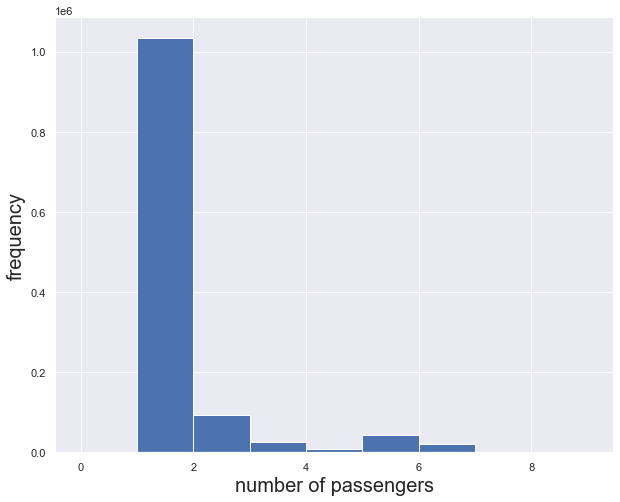

In [18]:
plt.figure(figsize=(10,8))
plt.hist(df.passenger_count, bins=9);
plt.xlabel('number of passengers', fontsize=20);
plt.ylabel('frequency', fontsize=20);

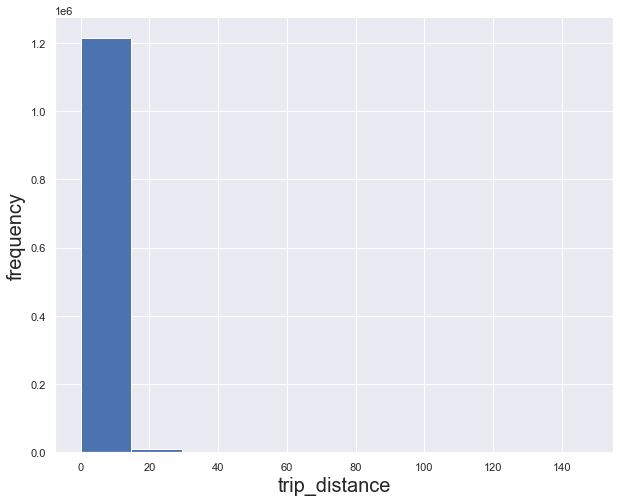

In [19]:
# trip_distance
plt.figure(figsize=(10,8))
plt.hist(df.trip_distance);
plt.xlabel('trip_distance', fontsize=20);
plt.ylabel('frequency', fontsize=20);

(0.0, 20.0)

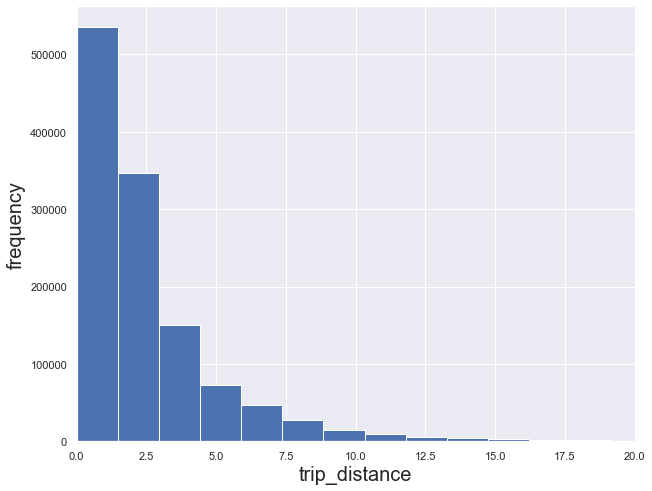

In [20]:
# removing outliers (that 1 day & 17 hours trip)
plt.figure(figsize=(10,8))
plt.hist(df.trip_distance, bins=100);
plt.xlabel('trip_distance', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim([0,20])

In [21]:
# column "fare_amount"
# we have many negative fares upto -$500
# the maximum is about $1000
print(sorted(set(df.fare_amount)))

[-499.0, -450.0, -400.0, -230.0, -200.0, -175.0, -155.0, -150.0, -145.0, -142.0, -140.0, -138.0, -135.0, -130.0, -127.5, -125.0, -120.0, -115.0, -110.0, -100.0, -95.0, -92.0, -85.0, -78.0, -75.0, -70.0, -66.0, -65.0, -60.0, -55.0, -52.0, -50.0, -45.0, -44.44, -40.0, -37.3, -35.8, -35.0, -32.0, -30.0, -29.5, -29.0, -27.8, -27.0, -26.0, -25.0, -23.3, -22.0, -21.5, -21.22, -20.8, -20.5, -20.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -1.0, -0.15, -0.05, 0.0, 0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.14, 0.15, 0.17, 0.2, 0.23, 0.24, 0.25, 0.3, 0.42, 0.5, 0.55, 0.68, 0.7, 0.8, 1.0, 1.1, 1.2, 1.28, 1.3, 1.4, 1.5, 1.6, 1.7, 2.0, 2.1, 2.2, 2.3, 2.33, 2.4, 2.5, 2.7, 2.8, 3.0, 3.01, 3.2, 3.5, 3.52, 4.0, 4.03, 4.5, 4.54, 4.6, 4.7, 4.8, 5.0, 5.05, 5.25, 5.3, 5.5, 5.54, 5.55, 5.56, 5.8, 6.0, 6.03, 6.07, 6.3, 6.5, 6.58, 6.66, 6.7, 6.8, 7.0, 7.09, 7.2, 7.24

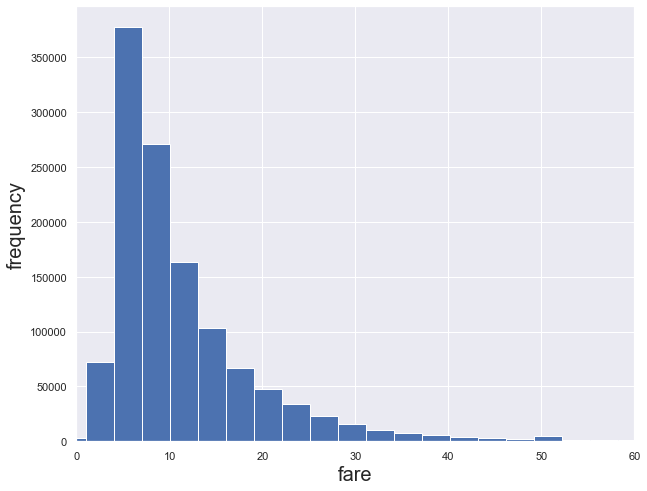

In [22]:
# but the majority are between $0-60
plt.figure(figsize=(10,8))
plt.hist(df.fare_amount, bins=500)
plt.xlabel('fare', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim(0,60);

In [23]:
# column "extra"
set(df.extra)

{-4.5, -1.0, -0.5, 0.0, 0.22, 0.5, 0.54, 1.0, 4.5}

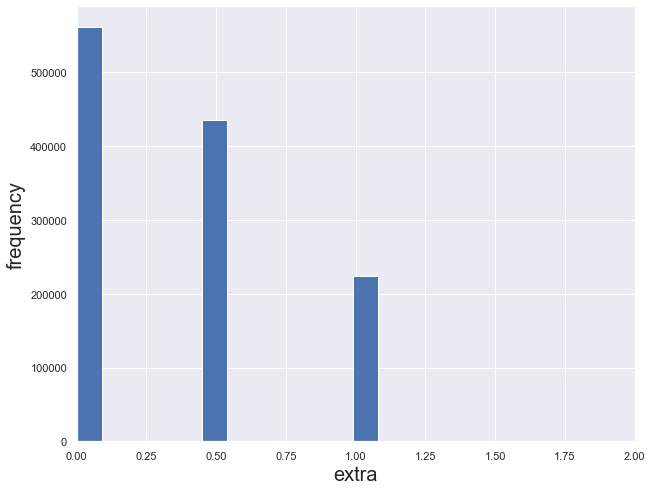

In [24]:
# the majority are either 0, .5, or 1
plt.figure(figsize=(10,8))
plt.hist(df.extra, bins=100);
plt.xlabel('extra', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim(0,2);

In [25]:
# column "mta_tax"
set(df.mta_tax)

{-0.5, 0.0, 0.5}

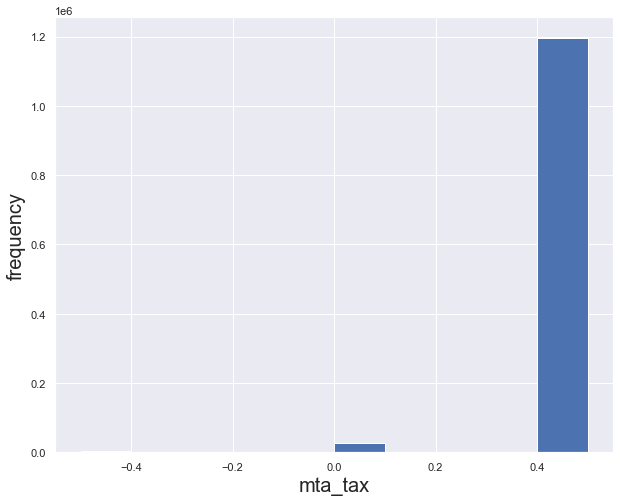

In [26]:
# the majority are either .5, some 0
plt.figure(figsize=(10,8))
plt.hist(df.mta_tax, bins=10);
plt.xlabel('mta_tax', fontsize=20);
plt.ylabel('frequency', fontsize=20);

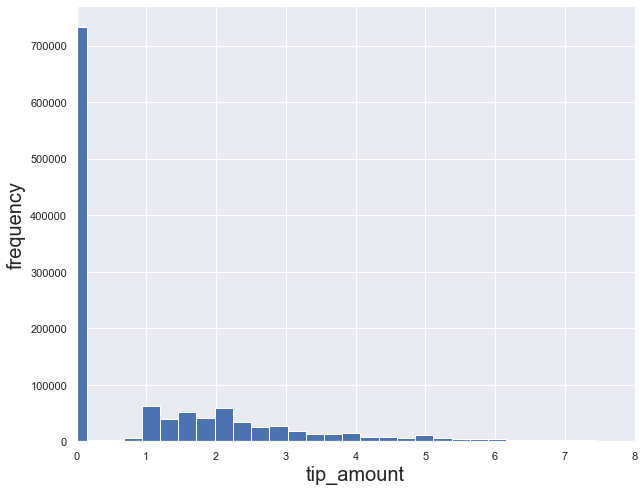

In [27]:
# column "tip_amount"
plt.figure(figsize=(10,8))
plt.hist(df.tip_amount, bins=1000);
plt.xlabel('tip_amount', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim(0,8);

In [28]:
# column "tolls_amount"
df.tolls_amount.value_counts()

0.00     1204620
5.54       17003
2.54         935
10.50        401
12.50        324
          ...   
13.04          1
4.62           1
4.50           1
14.00          1
5.63           1
Name: tolls_amount, Length: 126, dtype: int64

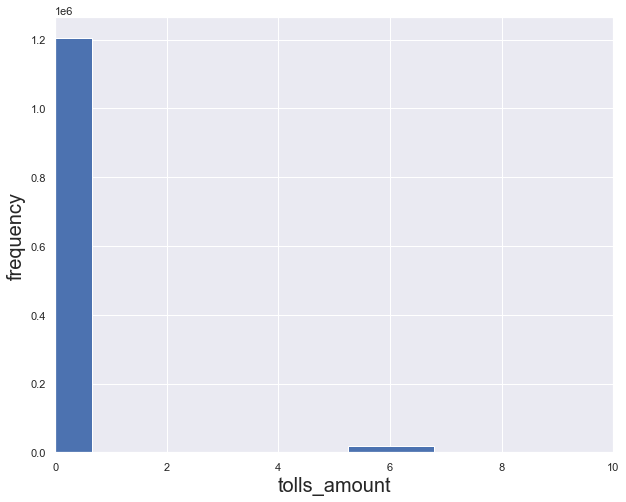

In [29]:
plt.figure(figsize=(10,8))
plt.hist(df.tolls_amount, bins=200);
plt.xlabel('tolls_amount', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim(0,10);

In [30]:
# column "improvement_surcharge"
set(df.improvement_surcharge)

{-0.3, 0.0, 0.3}

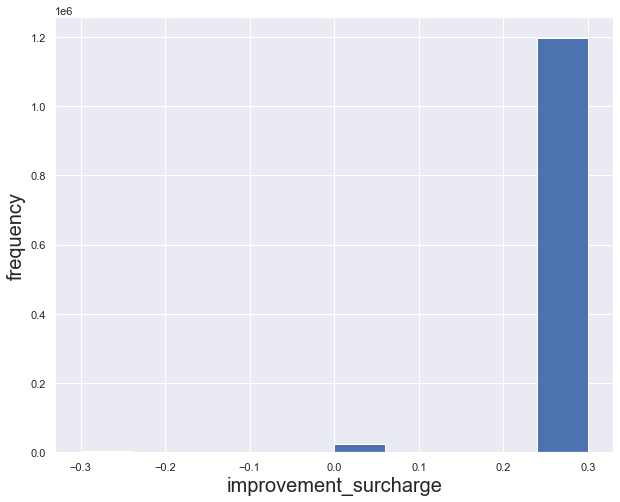

In [31]:
plt.figure(figsize=(10,8))
plt.hist(df.improvement_surcharge, bins=10);
plt.xlabel('improvement_surcharge', fontsize=20);
plt.ylabel('frequency', fontsize=20);

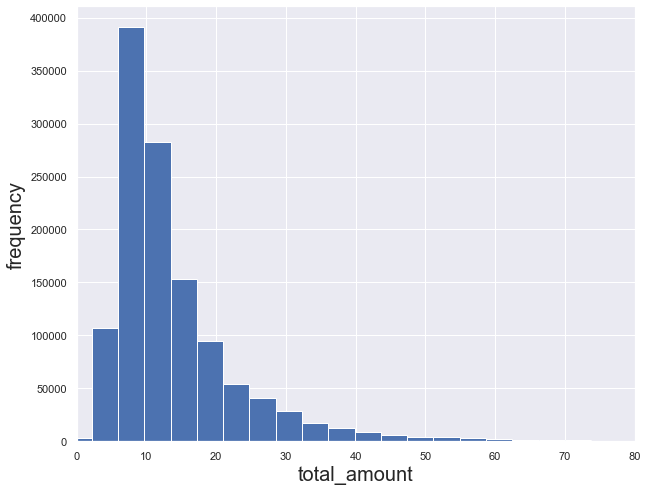

In [32]:
# column "total_amount"
plt.figure(figsize=(10,8))
plt.hist(df.total_amount, bins=400);
plt.xlabel('total_amount', fontsize=20);
plt.ylabel('frequency', fontsize=20);
plt.xlim(0,80);

In [33]:
# column "payment_type"
set(df.payment_type)

{1, 2, 3, 4, 5}

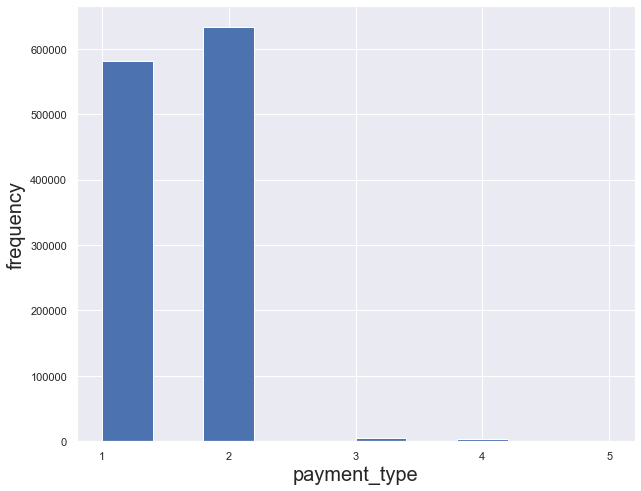

In [34]:
plt.figure(figsize=(10,8))
plt.hist(df.payment_type, bins=10);
plt.xlabel('payment_type', fontsize=20);
plt.xticks([1,2,3,4,5])
plt.ylabel('frequency', fontsize=20);

In [35]:
# column "trip_type"
set(df.trip_type)

{1, 2}

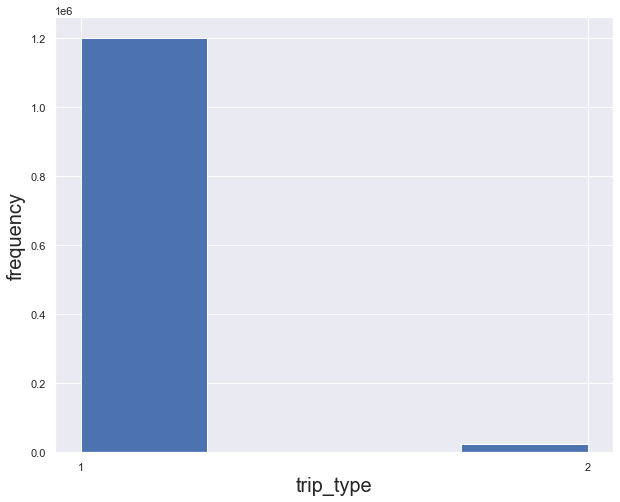

In [36]:
plt.figure(figsize=(10,8))
plt.hist(df.trip_type, bins=4);
plt.xlabel('trip_type', fontsize=20);
plt.xticks([1,2])
plt.ylabel('frequency', fontsize=20);

In [37]:
# interesting stats group by hour
df['hour'] = [x.hour for x in df.lpep_pickup_datetime]
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['tip_amount'].mean()

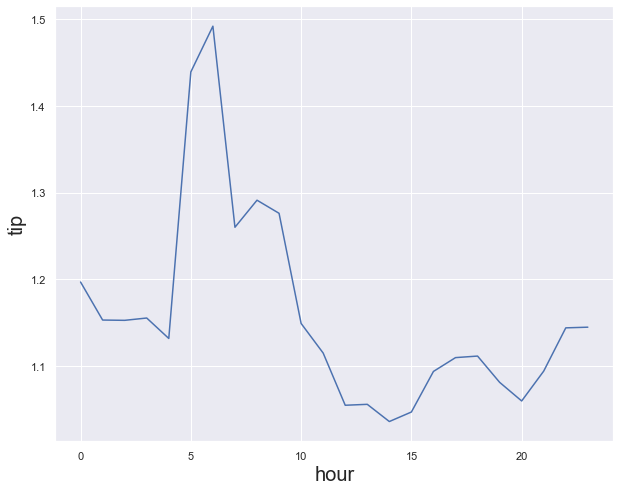

In [38]:
# plot average tip during different hours
# early morning passengers tip more!
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('tip', fontsize=20);

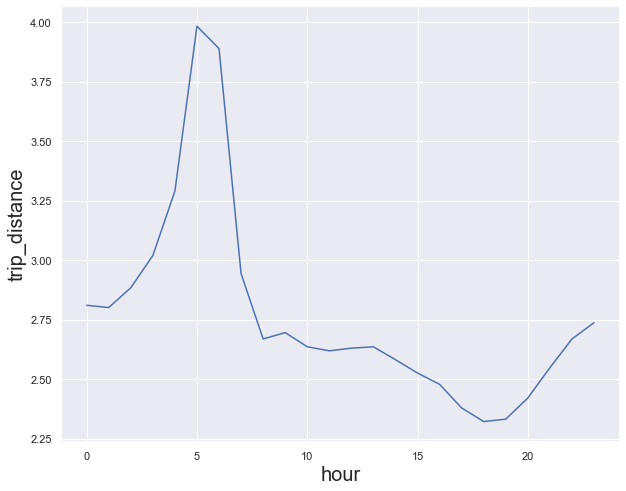

In [39]:
# but they also have longer trips, that may be the reason they tip more
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['trip_distance'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('trip_distance', fontsize=20);

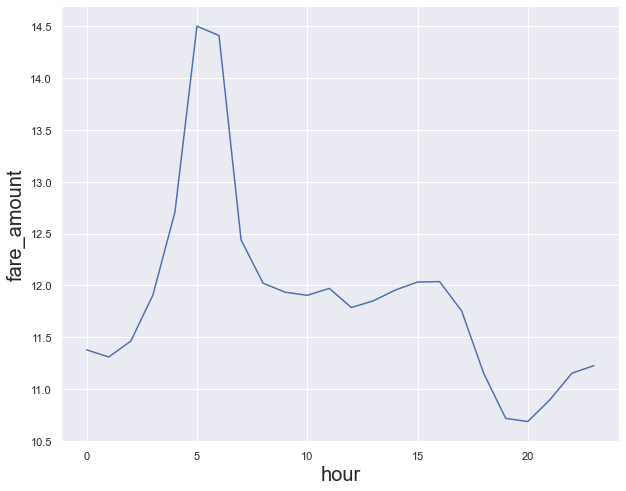

In [40]:
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['fare_amount'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('fare_amount', fontsize=20);

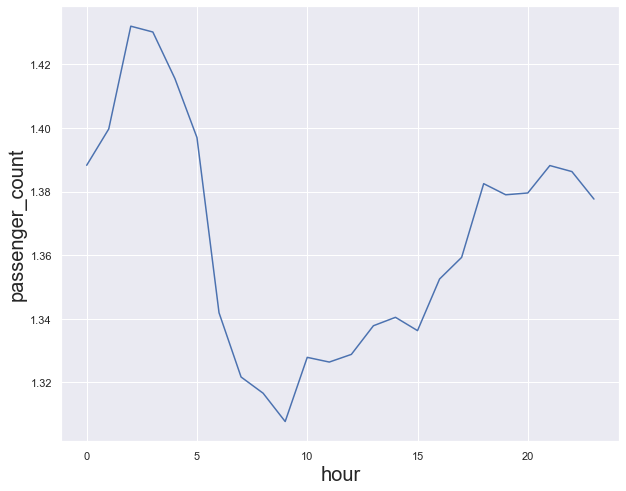

In [41]:
# at nights, number of passengers per trip increases, and peaks after midnight around 2-3am 
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['passenger_count'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('passenger_count', fontsize=20);

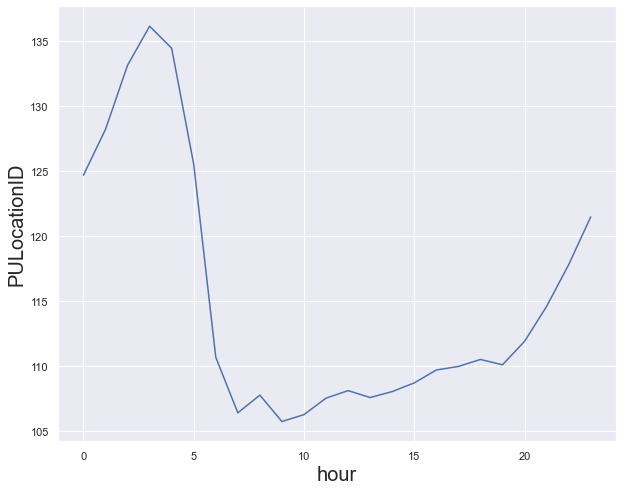

In [42]:
# the origin location shows differences, i.e. some locations have more early-mornign assengers than others
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['PULocationID'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('PULocationID', fontsize=20);

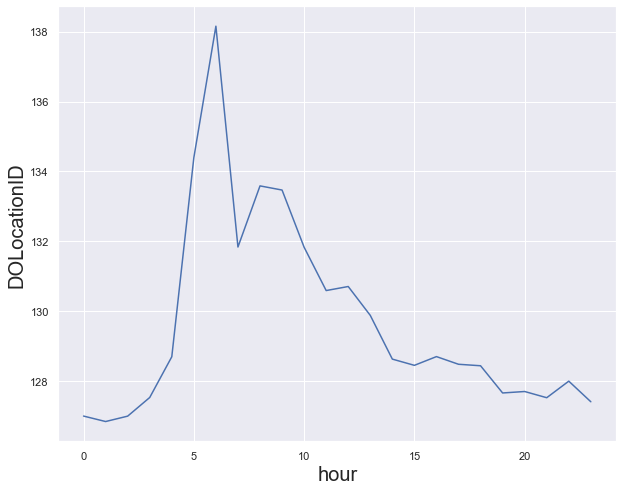

In [43]:
# the destination location also shows differences
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['DOLocationID'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('DOLocationID', fontsize=20);

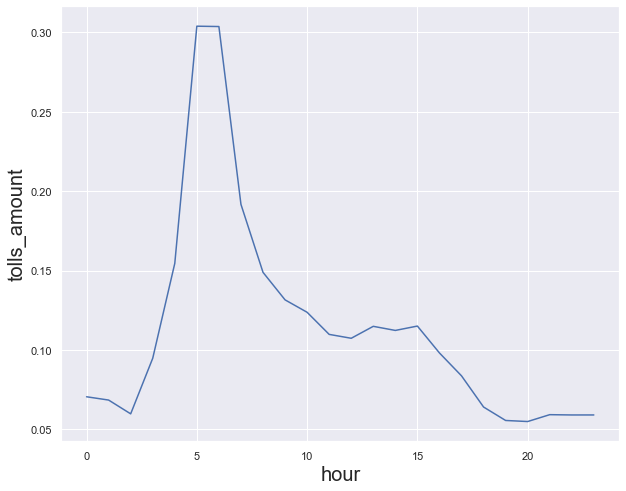

In [44]:
# early-morning trips also have more tolls 
dic = {}
for h,df_ in df.groupby('hour'):
    dic[h] = df_['tolls_amount'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('hour', fontsize=20);
plt.ylabel('tolls_amount', fontsize=20);

In [ ]:
# add the day of momth and the day of week features
df['weekday'] = [x.weekday() for x in df.lpep_pickup_datetime]
df['day'] = [x.day for x in df.lpep_pickup_datetime]

In [68]:
# split data into train / test sets
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=.15)

In [69]:
# independent variables, some are categorical, some numerical:
x_cats = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 
          'DOLocationID', 'payment_type', 'trip_type', 'weekday']
x_nums = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 
          'mta_tax', 'improvement_surcharge', 'hour', 'day']

In [70]:
# dependent variable:
y_train = df_train.tip_amount.values
y_test = df_test.tip_amount.values

In [71]:
# for categorical variables, we use OneHotEncoder and for numerical we just scale them by StandardScaler:
col_tr = ColumnTransformer([
                            ('num', StandardScaler(), x_nums),
                            ('cat', OneHotEncoder(handle_unknown='ignore'), x_cats),
                          ])

x_train = col_tr.fit_transform(df_train)
x_test  = col_tr.transform(df_test)

In [72]:
#check the shae of X and Y
x_train.shape, y_train.shape

((1040534, 528), (1040534,))

In [73]:
x_test.shape, y_test.shape

((183624, 528), (183624,))

In [74]:
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)
y_pred = lin_reg.predict(x_test)
print('r2_score:', r2_score(y_test,y_pred))

r2_score: 0.440398354185888


In [75]:
gboost = GradientBoostingRegressor()
gboost.fit(x_train,y_train)
y_pred = gboost.predict(x_test)
print('r2_score:', r2_score(y_test,y_pred))

r2_score: 0.5452898526008513


In [77]:
# trying on a limited version of features 
x_limited = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 
             'mta_tax', 'hour', 'day', 'weekday'] 
col_tr_limited = ColumnTransformer([
                                   ('num', StandardScaler(), x_limited),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'), []),
                          ])

x_train_limited = col_tr_limited.fit_transform(df_train)
x_test_limited  = col_tr_limited.transform(df_test)

In [78]:
x_train_limited.shape, y_train.shape

((1040534, 8), (1040534,))

In [79]:
lin_reg_limited = LinearRegression()
lin_reg_limited.fit(x_train_limited,y_train)
y_pred = lin_reg_limited.predict(x_test_limited)
print('r2_score:', r2_score(y_test,y_pred))

r2_score: 0.17716246209165876


In [82]:
# from this we can tell x1 (assenger_count) didn't have a significant effect on tip amount
# but all other variables (day of month, day of week, hour, trip distance, fare, extra and mta tax
# showed significant effects
sm_model = sm.OLS(y_train, x_train_limited).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.131
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                          1.956e+04
Date:                Fri, 16 Sep 2022   Prob (F-statistic):                        0.00
Time:                        07:25:33   Log-Likelihood:                     -2.3554e+06
No. Observations:             1040534   AIC:                                  4.711e+06
Df Residuals:                 1040526   BIC:                                  4.711e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.002      0.137      0.891      -0.004       0.005
x2             0.5497      0.004    136.581      0.000       0.542       0.558
x3             0.3905      0.004     96.917      0.000       0.383       0.398
x4             0.0359      0.002     14.802      0.000       0.031       0.041
x5             0.0481      0.002     20.679      0.000       0.044       0.053
x6            -0.0061      0.002     -2.568      0.010      -0.011      -0.001
x7            -0.0845      0.002    -37.004      0.000      -0.089      -0.080
x8            -0.0071      0.002     -3.063      0.002      -0.012      -0.003
==============================================================================
Omnibus:                  2161319.642   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      61103339361.828
Skew:                          16.921   Prob(JB):                         0.00
Kurtosis:                    1189.679   Cond. No.                         3.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# based on this limited analysis, the most important predictors, in order of importance, are:
# trip_distance (positive, the more distance the more tip)
# fare_amount (positive, which were expected since it is highly correlated with trip_distance)
# mta_tax (positive, moderate effect)
# extra (positive, small effect)

# all time-related parameters (hour, day of month, and day of week) have a significant and negative 
# effect of tip_amount...
# i.e. tips are at their peak early morning (~ 5 am); the more we progress through the day, it decreases
# similarly, tips are higher in the first half of month than the second-half

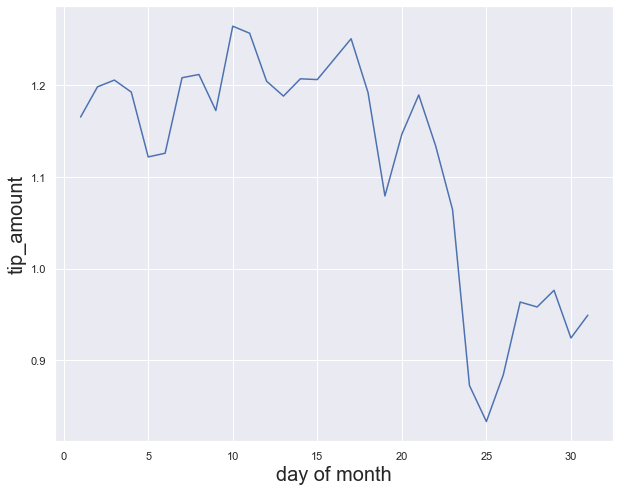

In [85]:
dic = {}
for h,df_ in df.groupby('day'):
    dic[h] = df_['tip_amount'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('day of month', fontsize=20);
plt.ylabel('tip_amount', fontsize=20);

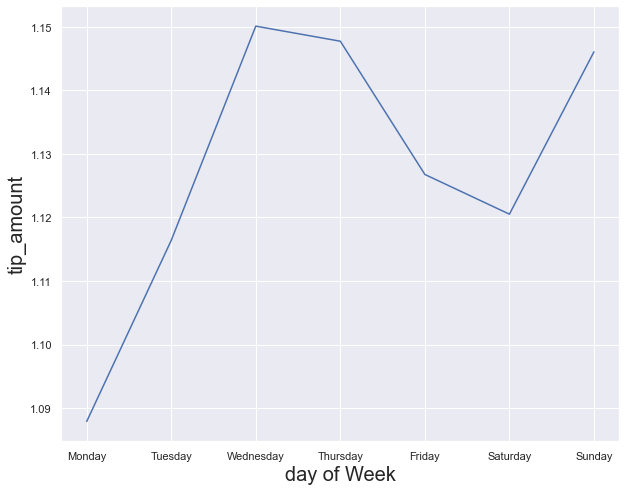

In [93]:
# Wed, Thu, and Sun are the highest_tip days in a week
# Mon and Tue are the lowest
dic = {}
for h,df_ in df.groupby('weekday'):
    dic[h] = df_['tip_amount'].mean()
plt.figure(figsize=(10,8))
plt.plot(dic.keys(), dic.values())
plt.xlabel('day of Week', fontsize=20);
plt.ylabel('tip_amount', fontsize=20);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

In [96]:
# previously we encountered an anomaly in the data where the difference between 
# pickup and dropoff times was 1 day and 17 hours. Now let's take a closer look at this case:
dif = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [100]:
max(dif)

Timedelta('1 days 17:27:54')

In [105]:
# adding a new column 'dif' which contains the time difference between pickup and dropoff
df['dif'] = [x.delta/1e9 for x in dif]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,hour,weekday,day,dif
0,2,2016-12-01 00:13:25,2016-12-01 00:25:41,N,1,225,65,1,2.79,11.0,...,0.00,0.0,0.3,12.30,2,1,0,3,1,736.0
1,2,2016-12-01 00:06:47,2016-12-01 00:08:52,N,1,255,255,1,0.45,3.5,...,0.96,0.0,0.3,5.76,1,1,0,3,1,125.0
2,1,2016-12-01 00:29:45,2016-12-01 00:34:21,N,1,41,42,1,1.20,6.0,...,0.00,0.0,0.3,7.30,3,1,0,3,1,276.0
3,1,2016-12-01 00:05:43,2016-12-01 00:11:56,N,1,80,255,1,1.40,6.5,...,0.00,0.0,0.3,7.80,2,1,0,3,1,373.0
4,1,2016-12-01 00:47:13,2016-12-01 01:02:59,N,1,255,189,1,3.50,13.5,...,3.70,0.0,0.3,18.50,1,1,0,3,1,946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224153,2,2016-12-31 23:30:44,2016-12-31 23:45:14,N,1,145,129,1,3.60,14.0,...,3.82,0.0,0.3,19.12,1,1,23,5,31,870.0
1224154,2,2016-12-31 23:06:19,2016-12-31 23:23:55,N,1,97,89,1,2.63,13.5,...,0.00,0.0,0.3,14.80,2,1,23,5,31,1056.0
1224155,2,2016-12-31 23:28:06,2016-12-31 23:34:30,N,1,188,190,1,1.29,7.0,...,0.00,0.0,0.3,8.30,2,1,23,5,31,384.0
1224156,1,2016-12-31 23:05:35,2016-12-31 23:11:41,N,1,116,244,2,1.00,6.5,...,1.00,0.0,0.3,8.80,1,1,23,5,31,366.0


In [106]:
max(df.dif)

149274.0

In [107]:
# this is the case with highest pickup/dropoff difference: 1 day 17 hours
df[df.dif==149274.0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,hour,weekday,day,dif
1167744,1,2016-12-30 20:49:52,2017-01-01 14:17:46,N,1,74,238,1,3.4,16.0,...,0.0,0.0,0.3,16.8,2,1,20,4,30,149274.0


In [108]:
# the trip distance is 3.4, the fare was $16, the tip was zero, ...
# all indicate a normal short trip. Therefore it's highly likely there was a mistake in entering the data
# this case occured around the end of month (day=30) and the dropoff date is the first day of the next year
# there might be some confusion in entering the date/time data at the border of months